### Score: `[30]`

Q1. `[10]` Good job!

Q2. `[10+10]` Good job! cbar的颜色可以有区分度一点，方便分清高低值就更好了

各题批注用`### Note`给出，请自行查阅。

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from cartopy.io import img_tiles
from datetime import datetime
from matplotlib.patches import FancyArrowPatch
import cftime

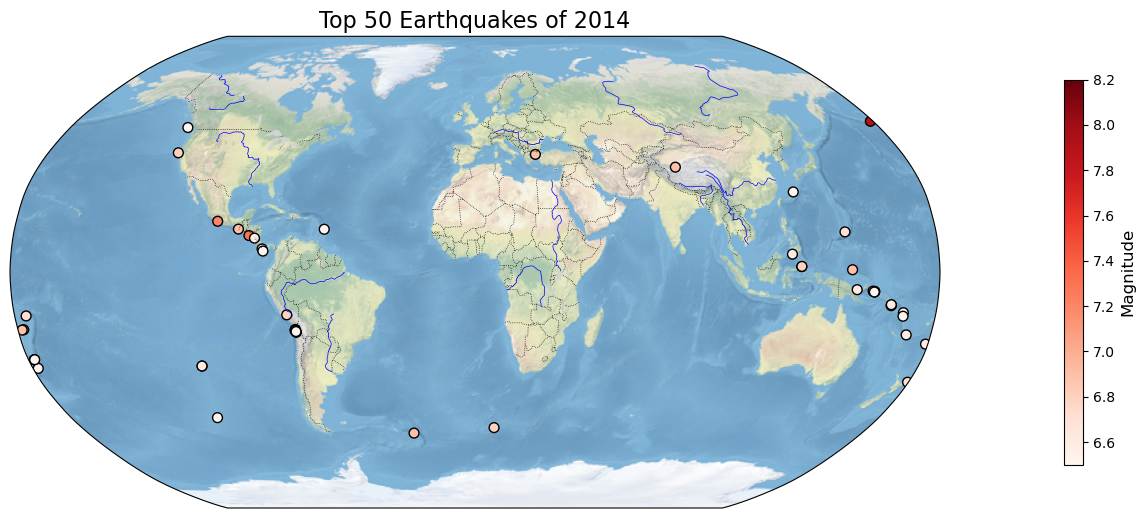

In [9]:
# 1. Global Earthquakes

# 读取CSV文件
file_path = 'usgs_earthquakes.csv' 
data = pd.read_csv(file_path)

# 提取所需列
columns_needed = ['latitude', 'longitude', 'depth', 'mag', 'time']
data = data[columns_needed]

# 确保震级列没有缺失值
data = data.dropna(subset=['mag'])

# 选择震级最大的前50个地震
top_earthquakes = data.nlargest(50, 'mag')

# 绘图
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection=ccrs.Robinson()) ### Note: 地图的中心经度可以在这里设置
ax.set_global()

# 添加地球阴影浮雕图作为背景
ax.stock_img()

# 添加地图特征
ax.add_feature(cfeature.LAND, facecolor='lightgreen')
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.RIVERS, linewidth=0.5, edgecolor='blue')
ax.add_feature(cfeature.LAKES, facecolor='lightgray')

# 绘制地震点
scatter = ax.scatter(
    top_earthquakes['longitude'],
    top_earthquakes['latitude'],
    c=top_earthquakes['mag'],
    cmap='Reds',
    s=50,
    transform=ccrs.PlateCarree(),
    edgecolor='black',
)

# 设置颜色条范围和间距
min_mag = top_earthquakes['mag'].min()  # 获取震级最小值
max_mag = top_earthquakes['mag'].max()  # 获取震级最大值

# 设置自定义的刻度范围和间距
ticks = np.arange(np.floor(min_mag), np.ceil(max_mag) + 0.2, 0.2)

# 添加颜色条
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', shrink=0.5, pad=0.1, ticks=ticks)
cbar.set_label('Magnitude', fontsize=12)

# 添加标题
plt.title('Top 50 Earthquakes of 2014', fontsize=16)

plt.show()

In [10]:
# 读取和合并 MERRA-2 数据
def read_and_merge_nc_merra2():
    # 创建2015到2018年每月的文件路径
    file_paths = [f'MERRA2_400.tavgM_2d_chm_Nx.{year}{month:02d}.nc4' for year in range(2015, 2019) for month in range(1, 13)]
    datasets = []

    # 遍历文件路径，读取并合并数据
    for file in file_paths:
        ds = xr.open_dataset(file)
        
        # 如果时间维度是cftime格式，转换为datetime64格式
        if isinstance(ds['time'].values[0], cftime.DatetimeNoLeap):
            ds['time'] = ds.indexes['time'].to_datetimeindex()
        
        datasets.append(ds)
    
    # 按照时间维度合并所有数据集
    merged_ds = xr.concat(datasets, dim="time")
    return merged_ds

# 调用函数读取和合并数据
ds_merra2 = read_and_merge_nc_merra2()

# 提取数据集中的所有可用变量
def get_available_variables(ds):
    return list(ds.data_vars)


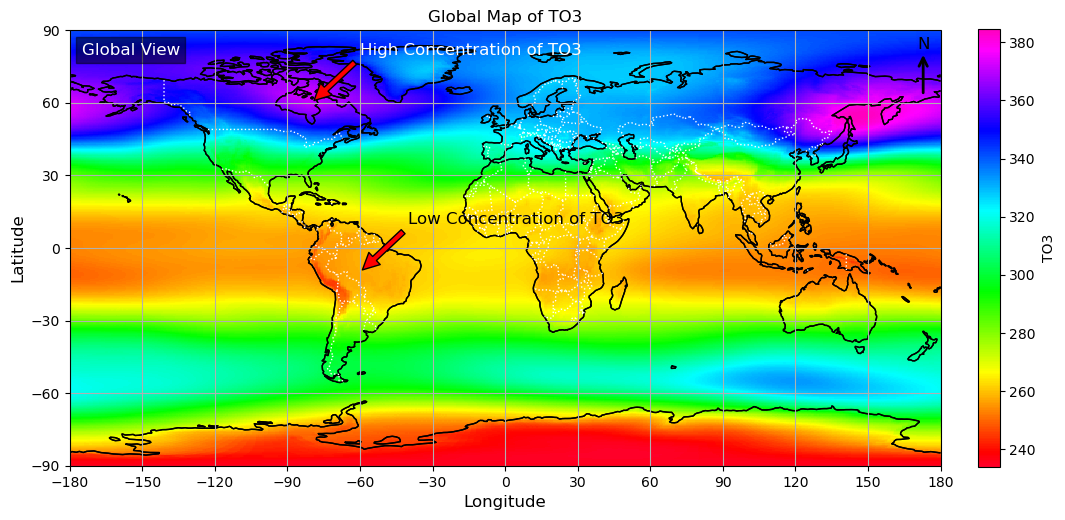

In [11]:
def plot_global_map(ds, var_name):
    # 获取所需变量的数据
    var_data = ds[var_name].mean(dim='time')  # 对时间维度求平均，得到空间分布

    # 创建一个全球地图投影
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 8))
    ax.set_global()  # 显示全球范围
    ax.coastlines()  # 添加海岸线

    # 绘制变量数据的颜色填充
    im = ax.pcolormesh(ds['lon'], ds['lat'], var_data, cmap='gist_rainbow', shading='auto')

    # 添加颜色条
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.0235, pad=0.04)
    cbar.set_label(var_name)

    # 添加海岸线和陆地特征
    ax.coastlines()
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    
    # 添加网格线
    ax.grid(True)

    # 设置标题
    ax.set_title(f'Global Map of {var_name}')

    # 添加x轴和y轴标签
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)

    # 添加坐标轴刻度
    ax.set_xticks(np.arange(-180, 181, 30))  # Longitude ticks every 30 degrees
    ax.set_yticks(np.arange(-90, 91, 30))   # Latitude ticks every 30 degrees
    ax.xaxis.set_ticks_position('bottom')  # Ensure ticks are at the bottom for longitude
    ax.yaxis.set_ticks_position('left')    # Ensure ticks are on the left for latitude

    # 设置坐标轴范围，避免坐标过于拥挤
    ax.set_xlim([-180, 180])  # Longitude range
    ax.set_ylim([-90, 90])    # Latitude range

    # 添加图例 (指北针)
    # 创建一个指北针图形
    arrow = FancyArrowPatch(
        posA=(0.98, 0.85), posB=(0.98, 0.95),  # 箭头起点和终点（相对坐标）
        arrowstyle='->', mutation_scale=15, color='black', linewidth=2, 
        transform=ax.transAxes  # Transform coordinates to axes-relative (0-1 range)
    )
    ax.add_patch(arrow)

    # 添加 "N" 字符标识指北针
    ax.text(0.98, 0.95, 'N', ha='center', va='bottom', fontsize=12, color='black', transform=ax.transAxes)
    
    # 添加文本框说明
    ax.text(-175, 80, 'Global View', fontsize=12, color='white', bbox=dict(facecolor='black', alpha=0.5))

    # 显示特定区域的特征
    ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='white')  # Borders
    ax.add_feature(cfeature.LAND, facecolor='red')  # Land feature

    # 额外注释
    ax.annotate('Low Concentration of TO3', xy=(-60, -10), xytext=(-40, 10),
                arrowprops=dict(facecolor='red', shrink=0.05),
                fontsize=12, color='black')

    ax.annotate('High Concentration of TO3', xy=(-80, 60), xytext=(-60, 80),
                arrowprops=dict(facecolor='red', shrink=0.05),
                fontsize=12, color='white')

    # 显示图像
    plt.show()

# 绘制全球地图
plot_global_map(ds_merra2, 'TO3')  


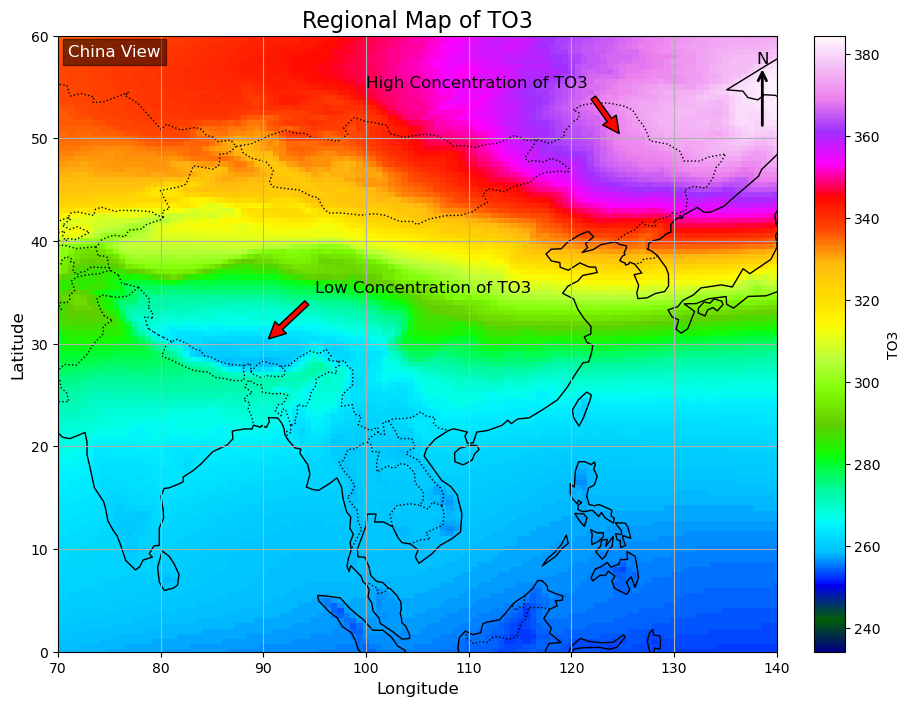

In [12]:
def plot_regional_map(ds, var_name, lat_range, lon_range):
    # 获取所需变量的数据
    var_data = ds[var_name].mean(dim='time')  # 对时间维度求平均，得到空间分布
    
    # 限制地图范围
    lon_min, lon_max = lon_range
    lat_min, lat_max = lat_range

    # 创建一个投影，设置图像大小
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 8))
    
    # 设置显示区域范围
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # 添加海岸线和陆地特征
    ax.coastlines()
    ax.add_feature(cfeature.LAND, facecolor='lightgray')

    # 绘制变量数据的颜色填充
    im = ax.pcolormesh(ds['lon'], ds['lat'], var_data, cmap='gist_ncar', shading='auto', transform=ccrs.PlateCarree())

    # 添加颜色条
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.035, pad=0.04)
    cbar.set_label(var_name)

    # 添加网格线
    ax.grid(True)

    # 添加标题
    ax.set_title(f'Regional Map of {var_name}', fontsize=16)

    # 添加x轴和y轴标签
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)

    # 添加坐标轴刻度
    ax.set_xticks(np.arange(lon_min, lon_max+1, 10))  # Longitude ticks every 10 degrees
    ax.set_yticks(np.arange(lat_min, lat_max+1, 10))   # Latitude ticks every 10 degrees
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    # 设置坐标轴范围
    ax.set_xlim([lon_min, lon_max])
    ax.set_ylim([lat_min, lat_max])

    # 添加图例 (指北针)
    # 创建一个指北针图形
    arrow = FancyArrowPatch(
        posA=(0.98, 0.85), posB=(0.98, 0.95),  # 箭头起点和终点（相对坐标）
        arrowstyle='->', mutation_scale=15, color='black', linewidth=2, 
        transform=ax.transAxes  # Transform coordinates to axes-relative (0-1 range)
    )
    ax.add_patch(arrow)

    # 添加 "N" 字符标识指北针
    ax.text(0.98, 0.95, 'N', ha='center', va='bottom', fontsize=12, color='black', transform=ax.transAxes)
    # 添加水体、边界等特征
    ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black')  # Example: Borders

    # 添加文本框说明
    ax.text(71, 58, 'China View', fontsize=12, color='white', bbox=dict(facecolor='black', alpha=0.5))

    # 额外注释
    ax.annotate('Low Concentration of TO3', xy=(90, 30), xytext=(95, 35),
                arrowprops=dict(facecolor='red', shrink=0.1),
                fontsize=12, color='black')

    ax.annotate('High Concentration of TO3', xy=(125, 50), xytext=(100, 55),
                arrowprops=dict(facecolor='red', shrink=0.1),
                fontsize=12, color='black')
    
    # 显示图像
    plt.show()

# 选择中国所在的经纬度地区
lat_range = (0, 60)   # Latitude bounds for Niño 3.4 region
lon_range = (70, 140)  # Longitude bounds for Niño 3.4 region

# 绘制区域地图
plot_regional_map(ds_merra2, 'TO3', lat_range, lon_range)  # Example variable 'TO3'